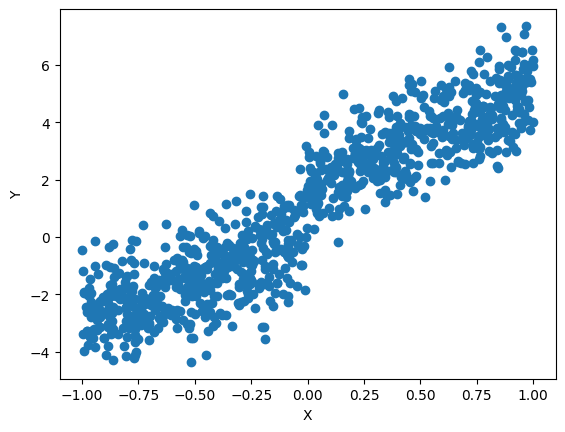

In [2]:
# ライブラリのインポート
# ------------------------------------------------------------
# ・numpy, pandas, matplotlib はいつもの科学計算セット。
# ・rdrobust, rddensity は回帰不連続デザイン（Regression Discontinuity Design, RDD）
#   を推定・診断するための専用ライブラリ。
#   - rdrobust: 局所線形回帰による処置効果（ジャンプ）の推定
#   - rddensity: カットオフ周りの密度の不連続性（マニピュレーションの有無）の検定
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import rdrobust
import rddensity

# 再現性のためにランダムシードを設定
# ------------------------------------------------------------
# 乱数を用いて疑似データを生成するので、結果を再現できるように固定。
np.random.seed(0)

# サンプルデータを生成
# ------------------------------------------------------------
# n : 観測データの数（サンプルサイズ）
n = 1000

# X : 「強制変数（running variable, forcing variable）」に相当。
#     - RDD では、X の値がカットオフを境にして処置が決まる。
#     - 例）テスト点数 X が 0 を超えたら奨学金付与、といった状況。
# 今回は -1 〜 1 の一様分布から生成している。
X = np.random.uniform(-1, 1, size=n)

# threshold : カットオフ値（cutoff）
# ------------------------------------------------------------
# X が threshold を超えるかどうかで処置割付が決まると仮定する。
threshold = 0

# treatment : 処置割当変数 D（0/1）
# ------------------------------------------------------------
# X が threshold より大きい場合に処置 D=1、それ以外は D=0 とする。
# これは「sharp RDD」（カットオフで処置確率が 0→1 に飛ぶタイプ）を想定した割付ルール。
treatment = (X > threshold).astype(int)

# Y : 結果変数（アウトカム）
# ------------------------------------------------------------
# 構造モデルとして
#   Y = 3 * X + 2 * D + ε
# を仮定している形になっている。
# ・3 * X       : running variable X の連続的な効果（ベースラインの傾き）
# ・2 * treatment:
#       カットオフを超えて処置を受けたことによる「ジャンプ」の大きさ（局所的処置効果）
#       → threshold 近傍では、処置群と対照群の間に平均で 2 の差が生じるように設計。
# ・np.random.normal(size=n):
#       誤差項 ε ~ N(0,1)（観測ノイズ）
Y = 3 * X + 2 * treatment + np.random.normal(size=n)

# データフレームの作成
# ------------------------------------------------------------
# RDD の推定では「Y（アウトカム）」「X（強制変数）」「処置 D」を
# 1 つのデータフレームで扱うと便利なので、この段階で整形しておく。
df = pd.DataFrame({"Y": Y, "X": X, "treatment": treatment})

# データの可視化
# ------------------------------------------------------------
# X（強制変数）と Y（アウトカム）の散布図を描く。
# ・理論的には、X=0 のところで Y の条件付き期待値に「ジャンプ」があれば、
#   それが局所的な因果効果（局所平均処置効果）として解釈できる。
# ・このプロットでは、X=0 を境に点の位置が縦にずれて見えるはずで、
#   その「段差」がおおよそ 2 になるように合成されている。
# 後で rdrobust を使って推定するジャンプのサイズを視覚的に確認するための第一歩。
plt.scatter(df["X"], df["Y"])
plt.xlabel("X")  # X軸のラベル（running variable）
plt.ylabel("Y")  # Y軸のラベル（outcome）
plt.show()  # グラフの表示